In [1]:
# Code below used from: https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
# modified to fit our project's needs

In [2]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline

In [3]:
df = pd.read_csv('SP.csv', index_col='Date');

In [4]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [5]:
def display_simulated_ef_with_random(table, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [6]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [7]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [8]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [9]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [10]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [11]:
# Our portfolios use the top 4 tickers for each criteria to save on the time cost of the program

In [12]:
df_sharpe = df[['AMT', 'BLL', 'CINF', 'SBUX']]


risk_free = 0.0212  #based on 6/22 T-bill rate 
returns = df_sharpe.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.54
Annualised Volatility: 0.14


              AMT    BLL   CINF   SBUX
allocation  32.55  34.49  16.29  16.66
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.51
Annualised Volatility: 0.13


              AMT   BLL  CINF   SBUX
allocation  39.47  17.6  25.3  17.63


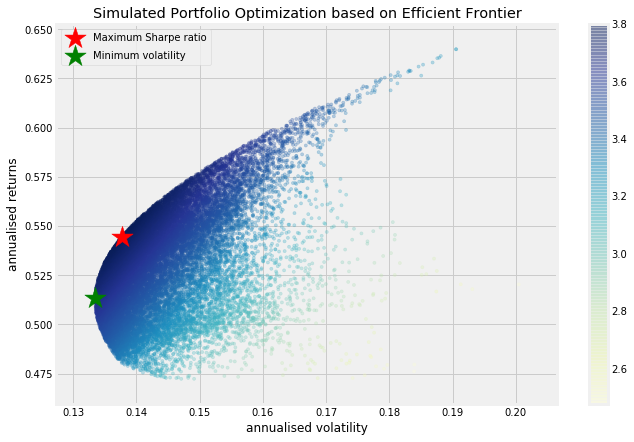

In [13]:
display_simulated_ef_with_random(df_sharpe, mean_returns, cov_matrix, num_portfolios, risk_free)

In [14]:
df_mean = df[['AMD', 'BLL', 'XLNX', 'SBUX']]


risk_free = 0.0212  #based on 6/22 T-bill rate 
returns = df_mean.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.61
Annualised Volatility: 0.17


             AMD    BLL  XLNX   SBUX
allocation  0.24  59.99  2.96  36.82
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.59
Annualised Volatility: 0.17


             AMD    BLL  XLNX  SBUX
allocation  0.35  48.49  3.56  47.6


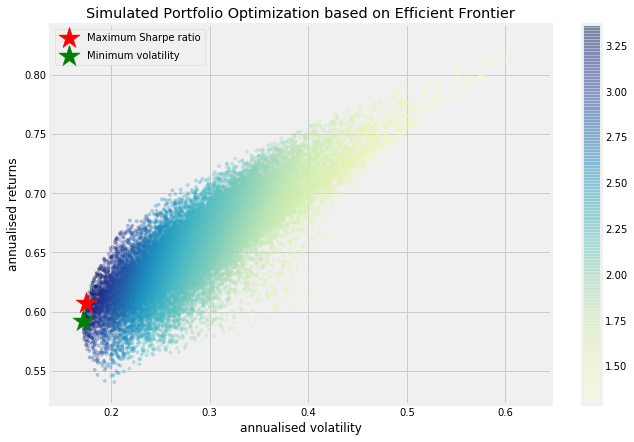

In [15]:
display_simulated_ef_with_random(df_mean, mean_returns, cov_matrix, num_portfolios, risk_free)

In [16]:
df_std = df[['RSG', 'EXC', 'DUK', 'NEE']]

risk_free = 0.0212  #based on 6/22 T-bill rate 
returns = df_std.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.27
Annualised Volatility: 0.12


              RSG   EXC   DUK    NEE
allocation  55.33  0.99  0.16  43.52
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.25
Annualised Volatility: 0.12


             RSG   EXC    DUK    NEE
allocation  54.7  4.34  23.67  17.29


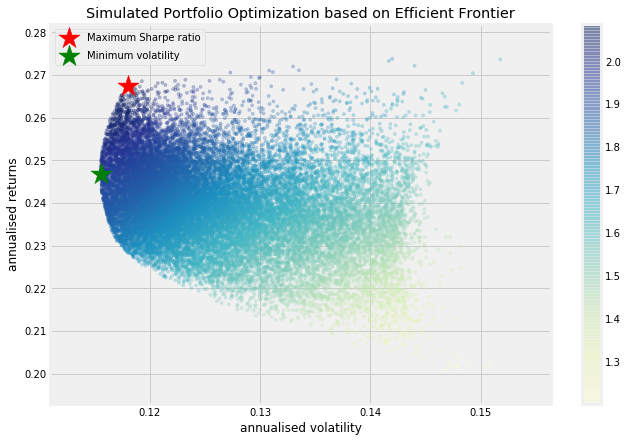

In [17]:
display_simulated_ef_with_random(df_std, mean_returns, cov_matrix, num_portfolios, risk_free)